# Configuation

In [3]:
# System and utilities
import os
import re
import time
import io
import base64
from collections import Counter
import unicodedata
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Natural Language Processing (NLP)
import nltk
import spacy
from nltk.corpus import stopwords

# Machine Learning & Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Image processing and display
from PIL import Image
from IPython.display import display
from IPython.core.display import HTML

# Progress bars
from tqdm import tqdm

# Custom modules
from auto_translate import AutoTranslate

# Exploring X_train and Y_train, and merging the tables

In [2]:
DATA_PATH = '../data/'


X_train = pd.read_csv(DATA_PATH  + 'X_train_update.csv')
X_test = pd.read_csv(DATA_PATH  + 'X_test_update.csv')
Y_train = pd.read_csv(DATA_PATH  + 'Y_train_CVw08PX.csv')

tables = [('X_train', X_train), ('X_test', X_test), ('Y_train', Y_train)]

# for table_name, table in tables:
#     print("\n"+"=" * 120)
#     print(f"\n{table_name}\n");
#     display(table.head());
#     display(table.info());
#     print(f"\nDuplicates:\n{table.duplicated().sum()}")
X_train = X_train[~X_train.index.duplicated(keep='first')]
Y_train = Y_train[~Y_train.index.duplicated(keep='first')]
X_train = X_train.merge(Y_train, how='left', left_index=True, right_index=True, suffixes=('_X_train', '_Y_train'))

X_train.drop(['prdtypecode_Y_train'], axis=1, inplace=True, errors='ignore')
X_train = X_train.rename(columns={'Unnamed: 0_X_train': 'Unnamed: 0'})

cols_to_drop = [col for col in X_train.columns if 'Unnamed' in str(col) or col in ['0', 'index', 'level_0']]
X_train.drop(cols_to_drop, axis=1, inplace=True, errors='ignore')
display(X_train.head(5))

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


## based on Simons category names and translations:

In [3]:
print('''Based on the observation of the word frequencies and wordclouds, we are in capacity to define the product types associated to each code''')

prdtypes = {
    10: ("Livres d'occasion", "Used Books"),
    40: ("Jeux vidéo", "Video Games"),
    50: ("Accessoires de jeux vidéo", "Video Game Accessories"),
    60: ("Consoles de jeux vidéo", "Video Game Consoles"),
    1140: ("Figurines Enfant", "Children's Figurines"),
    1160: ("Cartes à Collectionner", "Collectible Cards"),
    1180: ("Figurines Adulte et Jeux de role", "Adult Figurines and Role-Playing Games"),
    1280: ("Jouets", "Toys"),
    1281: ("Jeux de société", "Board Games"),
    1300: ("Jouets télécommandés", "Remote Control Toys"),
    1301: ("Chaussettes bébé", "Baby Socks"),
    1302: ("Pêche Enfant", "Children's Fishing"),
    1320: ("Puériculture", "Childcare"),
    1560: ("Mobilier intérieur", "Indoor Furniture"),
    1920: ("Literie", "Bedding"),
    1940: ("Alimentation", "Food"),
    2060: ("Décoration", "Decoration"),
    2220: ("Animaux", "Animals"),
    2280: ("Revues et Magazines", "Magazines and Journals"),
    2403: ("Lots Magazines, Livres et BDs", "Magazine, Book and Comic Bundles"),
    2462: ("Jeux d'occasion", "Used Games"),
    2522: ("Papeterie", "Stationery"),
    2582: ("Mobilier de jardin", "Garden Furniture"),
    2583: ("Equipement de piscine", "Pool Equipment"),
    2585: ("Entretien", "Maintenance"),
    2705: ("Livres neufs", "New Books"),
    2905: ("Jeux PC", "PC Games")
}

X_train['cat_name_fr'] = X_train['prdtypecode'].map(lambda x: prdtypes.get(x, ("NaN", "NaN"))[0])
X_train['cat_name_en'] = X_train['prdtypecode'].map(lambda x: prdtypes.get(x, ("NaN", "NaN"))[1])

Based on the observation of the word frequencies and wordclouds, we are in capacity to define the product types associated to each code


In [4]:
def combine_without_duplicates(designation, description):
    '''Combine designation and description, avoiding duplicates'''
    desig = str(designation).strip() if pd.notna(designation) else ''
    desc = str(description).strip() if pd.notna(description) else ''
    
    if not desig and not desc:
        return ''
    elif not desig:
        return desc
    elif not desc:
        return desig
    elif desig.lower() == desc.lower():  # Exact duplicates (case-insensitive)
        return desig
    elif desig.lower() in desc.lower():  # Designation contained in description
        return desc
    elif desc.lower() in desig.lower():  # Description contained in designation
        return desig
    else:
        return f"{desig} {desc}"  # Both are unique, combine them

# Replace your line with:


In [5]:
X_train['combined'] = X_train.apply(lambda row: combine_without_duplicates(row['designation'], row['description']), axis=1)


In [6]:
X_train.to_csv(DATA_PATH + 'X_train_text_comb.csv', index=False)

# Data inspection


### Unique Product Type Codes


There are 27 distinct product type codes.


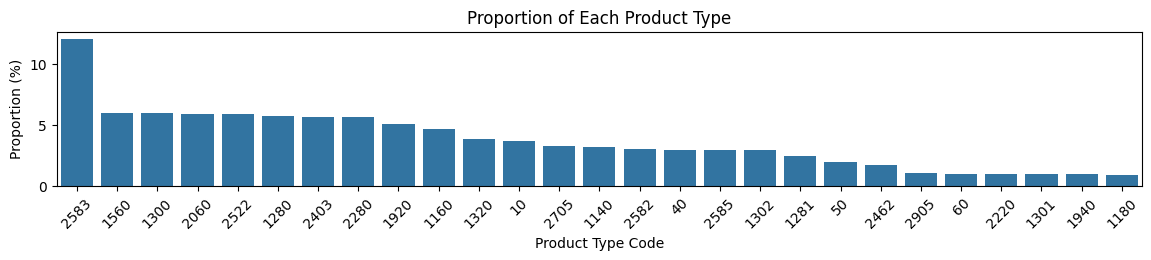

In [7]:
prdtypecode_proportions = Y_train['prdtypecode'].value_counts(normalize=True) * 100
prdtypecode_count = Y_train['prdtypecode'].nunique()
print(f"\nThere are {prdtypecode_count} distinct product type codes.")
prdtypecode_proportions = prdtypecode_proportions.sort_values(ascending=False)

plt.figure(figsize=(14, 2))
sns.barplot(x=prdtypecode_proportions.index, y=prdtypecode_proportions.values, order=prdtypecode_proportions.index)
plt.title('Proportion of Each Product Type')
plt.xlabel('Product Type Code')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.show()

### Products with no product description

In [8]:
proportion_null_descriptions_X_train = (X_train["description"].isnull().sum() / X_train["description"].shape[0]) * 100
print(f"The proportion of null descriptions in X_train is {proportion_null_descriptions_X_train:.1f}%")

proportion_null_descriptions_X_test = (X_test["description"].isnull().sum() / X_test["description"].shape[0]) * 100
print(f"The proportion of null descriptions in X_test is {proportion_null_descriptions_X_test:.1f}%")


The proportion of null descriptions in X_train is 35.1%
The proportion of null descriptions in X_test is 35.4%


### Generating a Wordclouds for each category

In [4]:
# Download French stopwords
nltk.download('stopwords')

# Load French stopwords and add custom ones
french_stopwords = set(stopwords.words('french'))
german_stopwords = set(stopwords.words('german'))
italian_stopwords = set(stopwords.words('italian'))
custom_stopwords = {
    # Balises et éléments HTML/CSS courants
    'br', 'nbsp', 'quot', 'http', 'https', 'www', 'img', 'src', 'alt',
    'div', 'span', 'style', 'class', 'border', 'font', 'color',

    # formatts and CS:
    'env', 'bib',

    # Descriptions and measures
    'voir', 'photo', 'plus', 'cm', 'mm', 'kg', 'ml', 'x', 'l', 'm', 's',
    'taille', 'produit', 'prix', 'offre', 'détails', 'neuf', 'garantie',
    'qualite', 'qualité', 'sans', 'type', 'chez', 'être', 'tout', 'dont',
    'assez', 'dimension', 'dimensions', 'format', 'etat', 'lot', 'paquet', 'pack',
    'modèle', 'marque', 'couleur', 'couleurs', 'matière', 'matériau', 'matériaux',
    'usage', 'utilisation', 'occasion', 'vente', 'commerce', 'collection', 'édition',
    'vol',

    # COlors courantes en français
    'blanc', 'blanche', 'noir', 'noire', 'rouge', 'bleu', 'bleue', 'vert', 'verte', 'jaune',
    'gris', 'grise', 'orange', 'rose', 'marron', 'violet', 'violette', 'turquoise', 'beige',
    'argent', 'doré', 'dorée', 'or', 'cuivre', 'cyan', 'indigo', 'lavande', 'saumon', 'bordeaux',

    # Common english words
    'the', 'of', 'or', 'a', 'agrave', 'and', 'in', 'to', 'for', 'i', 'is', 'it', 'on',
    'with', 'this', 'that', 'by', 'from', 'as', 'at', 'an', 'be', 'are',

    # Mots isolés ou symboles, ponctuation
    'gt', 'p', 'e', 'eacute', 'egrave', 'ecirc', 'g', 'f', 'r', 'v', 'si', 'aussi',
    'h', 'â', 'très', 'peut', 'rsquo', 'd\'', 'l\'', 'qu\'', 'j\'', 'n\'',

    # Adjectifves and adverbs
    'grand', 'grande', 'petit', 'petite', 'même', 'autre', 'autres', 'ancien', 'ancienne',
    'nouveau', 'nouvelle', 'possible', 'certain', 'seul', 'seule', 'différent', 'différente',

    # Verbs and auxiliaries
    'avoir', 'être', 'faire', 'pouvoir', 'aller', 'venir', 'devoir', 'prendre', 'mettre',
    'dire', 'vouloir', 'savoir', 'falloir', 'voir', 'demander', 'trouver', 'donner',

    # Common ecommerce terms 
    'livraison', 'service', 'client', 'qualité', 'offert', 'offrir', 'occasion', 'garantie',
    'retour', 'facture', 'commande', 'référence', 'stock', 'disponible', 'promo', 'promotion',
    'échange', 'reprise', 'remise', 'prix', 'paiement', 'mode', 'de', 'à',

    # Short connectors courtes et connecteurs
    'et', 'ou', 'mais', 'donc', 'or', 'ni', 'car', 'par', 'pour', 'sur', 'sans', 'avec',
    'dans', 'entre', 'chez', 'vers', 'contre', 'depuis', 'avant', 'après', 'pendant', 

    # Letter numbers
    'un', 'une', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix',
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'ein', 'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun', 'zehn', 'elf', 'zwölf',

    # Noms génériques et trop fréquents en ecommerce
    'accessoire', 'accessoires', 'outil', 'outils', 'élément', 'éléments', 'pièce', 'pièces',
    'article', 'articles', 'ensemble', 'ensembles', 'set', 'kits', 'kit'

    # random miscellaneous words
    'alors', 'aucun', 'aussi', 'autre', 'avant', 'avoir', 'car', 'cela', 
    'ces', 'ceux', 'chaque', 'comme', 'comment', 'dans', 'des', 'deux', 
    'donc', 'elle', 'elles', 'encore', 'fait', 'fois', 'font', 'haut', 
    'ici', 'ils', 'juste', 'leur', 'maintenant', 'mais', 'même', 'moins', 
    'notre', 'nous', 'peut', 'peu', 'pour', 'pourquoi', 'quand', 'quel', 
    'quelle', 'sans', 'sera', 'sous', 'tout', 'tous', 'très', 'votre', 
    'vous', 'étaient', 'été', 'être', 'oui'
}

all_stopwords = french_stopwords.union(custom_stopwords).union(german_stopwords).union(italian_stopwords)


# Define your word grouping dictionary (lemmatization-like rules)
word_grouping = {
    'livres': 'livre',
    'jeux': 'jeu',
    'toy':'jeu',
    'jouets':'jouet',
    'enfants':'enfant',
    'agrave': 'a',
    'eacute': 'e',
    'egrave': 'e',
    'ecirc': 'e',
    'gravures': 'gravure',
    'car':'voiture',
    'tools': 'outils'
}

[nltk_data] Downloading package stopwords to /home/sameer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
DATA2SHARE_PATH = '../data2share/'
np.save(DATA2SHARE_PATH + 'all_stopwords.npy', list(all_stopwords), allow_pickle=True)
all_stopwords

{'a',
 'abbia',
 'abbiamo',
 'abbiano',
 'abbiate',
 'aber',
 'accessoire',
 'accessoires',
 'acht',
 'ad',
 'agl',
 'agli',
 'agrave',
 'ai',
 'aie',
 'aient',
 'aies',
 'ait',
 'al',
 'all',
 'alla',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'allo',
 'als',
 'also',
 'alt',
 'am',
 'an',
 'anche',
 'ancien',
 'ancienne',
 'and',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders',
 'après',
 'are',
 'argent',
 'article',
 'articles',
 'as',
 'assez',
 'at',
 'au',
 'auch',
 'aucun',
 'auf',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aus',
 'aussi',
 'autre',
 'autres',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avemmo',
 'avendo',
 'avesse',
 'avessero',
 'avessi',
 'avessimo',
 'aveste',
 'avesti',
 'avete',
 'aveva',
 'avevamo',
 'avevano',
 'avevate',
 'avevi',
 'avevo',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',

In [11]:
translate = AutoTranslate("en")

In [14]:
import unicodedata
import re
import spacy
from langdetect import detect

# Load spaCy models - install these first
def load_spacy_models():
    models = {}
    try:
        models['fr'] = spacy.load("fr_core_news_sm")
    except OSError:
        print("French model not found. Install with: python -m spacy download fr_core_news_sm")
        models['fr'] = None
    
    try:
        models['en'] = spacy.load("en_core_web_sm") 
    except OSError:
        print("English model not found. Install with: python -m spacy download en_core_web_sm")
        models['en'] = None
        
    try:
        models['de'] = spacy.load("de_core_news_sm")
    except OSError:
        print("German model not found. Install with: python -m spacy download de_core_news_sm")
        models['de'] = None
    
    return models

# Load models once
SPACY_MODELS = load_spacy_models()

def clean_text(text):
    if not isinstance(text, str):
        return []
    
    manual_translations = {
        'monde': 'world', 'enfant': 'child', 'enfants': 'child', 'voiture': 'car', 'maison': 'house',
        'revue': 'magazine', 'livre': 'book', 'vie': 'life', 'doudou': 'stuffed animal',	
        'gravure': 'engraving', 'gravures': 'engraving', 'haute': 'high', 'jardin': 'garden', 'facile': 'easy',
        'chaise': 'chair', 'bois': 'wood', 'diffe': 'different', 'ditions': 'editions',
        'dition': 'edition', 'eau': 'water', 'titres': 'titles', 'collier': 'necklace', 'sac': 'bag',
        'chien': 'dog', 'masque': 'mask', 'commune': 'common', 'guerre': 'war', 'cumple': 'couple'
    }
    
    # 1. Detect language
    detected_lang = 'fr'  # Default to French
    try:
        detected_lang = detect(text)
        #print(f"Detected language: {detected_lang}")
    except Exception as e:
        print(f"Language detection failed: {e}, using French as default {text[:50]}")
    
    # 2. Basic text cleaning
    text = unicodedata.normalize('NFD', text).lower()
    
    # Handle French contractions
    contractions = {
        r"\bl'": "le ", r"\bd'": "de ", r"\bc'": "ce ", r"\bj'": "je ",
        r"\bn'": "ne ", r"\bm'": "me ", r"\bt'": "te ", r"\bs'": "se ",
        r"\bqu'": "que "
    }
    for pattern, replacement in contractions.items():
        text = re.sub(pattern, replacement, text)
    
    # Replace ligatures and remove HTML
    text = text.replace('œ', 'oe').replace('æ', 'ae')
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Keep French characters and normalize whitespace
    text = re.sub(r'[^a-zàâäçéèêëîïôöûùüÿñ\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 3. spaCy POS tagging and filtering
    cleaned_tokens = []
    
    # Choose appropriate spaCy model
    nlp = None
    if detected_lang in SPACY_MODELS and SPACY_MODELS[detected_lang]:
        nlp = SPACY_MODELS[detected_lang]
    elif SPACY_MODELS['fr']:  # Fallback to French
        nlp = SPACY_MODELS['fr']
    elif SPACY_MODELS['en']:  # Fallback to English
        nlp = SPACY_MODELS['en']
    
    if nlp:
        try:
            # Process text with spaCy
            doc = nlp(text)
            
            for token in doc:
                # Filter: only nouns and verbs, skip short words and stopwords
                if (token.pos_ in ['NOUN', 'VERB'] and 
                    len(token.text) > 2 and 
                    not token.is_stop and
                    token.text.lower() not in all_stopwords):
                    
                    word_text = token.text.lower()
                    
                    # Apply manual translations first
                    if word_text in manual_translations:
                        cleaned_tokens.append(manual_translations[word_text])
                    # Apply word grouping
                    elif word_text in word_grouping:
                        cleaned_tokens.append(word_grouping[word_text])
                    else:
                        cleaned_tokens.append(word_text)
                        
        except Exception as e:
            print(f"spaCy processing failed: {e}, using fallback")
            cleaned_tokens = fallback_method(text, manual_translations)
    else:
        print("No spaCy models available, using fallback method")
        cleaned_tokens = fallback_method(text, manual_translations)
    
    return cleaned_tokens

def fallback_method(text, manual_translations):
    """Fallback method without POS tagging"""
    tokens = text.split()
    cleaned_tokens = []
    
    for w in tokens:
        if w not in all_stopwords and len(w) > 2:
            # if w in manual_translations:
            #     cleaned_tokens.append(manual_translations[w])
            if w in word_grouping:
                cleaned_tokens.append(word_grouping[w])
            else:
                cleaned_tokens.append(w)
    
    return cleaned_tokens



In [15]:
X_train['comb_tokens'] = X_train['combined'].dropna().astype(str).apply(clean_text)

In [16]:
X_train.to_csv(DATA_PATH + 'X_train_text_comb.csv', index=False)

In [1]:

# Get product types
product_types = X_train['prdtypecode'].unique()

top = 100
get_english = False # Set to True to translate words to English
save_dictionary = True  # Set to True to save the top words in a dictionary
top_data = {}
top_data['product_type'] = []
top_data['designation'] = []
top_data['description'] = []
top_data['combined'] = []

for idx, prd_type in enumerate(product_types[:]):
    type_data = X_train[X_train['prdtypecode'] == prd_type]
    type_data = type_data.copy()
    
    designation_tokens = type_data['designation'].dropna().astype(str).apply(clean_text).sum()
    description_tokens = type_data['description'].dropna().astype(str).apply(clean_text).sum()
    combined_tokens = type_data['combined'].dropna().astype(str).apply(clean_text).sum()

    # designation_text = ' '.join(designation_tokens)
    # description_text = ' '.join(description_tokens)
    # full_text = ' '.join(combined_tokens)

    # Frequency counts separately
    designation_counts = Counter(designation_tokens)
    description_counts = Counter(description_tokens)
    combined_counts = Counter(combined_tokens)

    top_designation = designation_counts.most_common(top)
    top_description = description_counts.most_common(top)
    top_combined = combined_counts.most_common(top)

    top_data['product_type'].append(prd_type)

    if get_english:
        top_data['designation'].append([(translate.translate(word), freq) for word, freq in top_designation])
        top_data['description'].append([(translate.translate(word), freq) for word, freq in top_description])
        top_data['combined'].append([(translate.translate(word), freq) for word, freq in top_combined])


    else:

        top_data['designation'].append(top_designation)
        top_data['description'].append(top_description)
        top_data['combined'].append(top_combined)
        
    df_designation = pd.DataFrame(top_designation, columns=['Word (Designation)', 'Frequency'])
    df_description = pd.DataFrame(top_description, columns=['Word (Description)', 'Frequency'])
    df_combined = pd.DataFrame(top_combined, columns=['Word (combined)', 'Frequency'])
    if idx % 5 == 0:
        print(f"\nProcessing product type {prd_type} ({idx + 1}/{len(product_types)})")
        # Display top 20 words side-by-side
        display(HTML(f"<h3>Top 20 Words for Product Type {prd_type}</h3>"))
        display(pd.concat([df_designation, df_description, df_combined], axis=1))

        # Print product samples
        print(f"\n📦 Sample Products for Product Type {prd_type}")
        print("=" * 60)
        display(type_data[['designation', 'description', 'combined']].sample(min(5, len(type_data)), random_state=42))

        # Other stats
        print(f"\n📊 Stats for Product Type {prd_type}")
        print("=" * 60)
        print(f"Products: {len(type_data)}")
        print(f"Unique designations: {type_data['designation'].nunique()}")
        print(f"Unique descriptions: {type_data['description'].nunique()}")
        print(f"Unique combined: {type_data['combined'].nunique()}")
        print(f"Avg designation length: {type_data['designation'].str.len().mean():.0f} characters")
        print(f"Avg description length: {type_data['description'].str.len().mean():.0f} characters")
        print(f"Avg combined length: {type_data['combined'].str.len().mean():.0f} characters")
        print("\n" + "=" * 60 + "\n")
if save_dictionary:
    # Save the top words in a dictionary
    print(f"Saving top {top} words in a dictionary...")
    np.save(DATA_PATH + f'top_{top}_fr_data.npy', top_data, allow_pickle=True)

NameError: name 'X_train' is not defined

In [ ]:
# Set to True to translate words to English
start_time = time.time()
for prd_type in product_types[:5]:
    type_data = X_train[X_train['prdtypecode'] == prd_type]
    type_data = type_data.copy()
    type_data['combined'] = type_data.apply(lambda row: combine_without_duplicates(row['designation'], row['description']), axis=1)
    
    designation_tokens = type_data['designation'].dropna().astype(str).apply(clean_text).sum()
    description_tokens = type_data['description'].dropna().astype(str).apply(clean_text).sum()
    combined_tokens = type_data['combined'].dropna().astype(str).apply(clean_text).sum()
    #combined_tokens2 = [translate.translate(word) for word in combined_tokens if word] if get_english else combined_tokens

    designation_text = ' '.join(designation_tokens)
    description_text = ' '.join(description_tokens)
    combined_text = ' '.join(combined_tokens)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

    if designation_text:
        wc1 = WordCloud(width=800, height=400, background_color='white',
                        colormap='Reds', max_words=100).generate(designation_text)
        ax1.imshow(wc1, interpolation='bilinear')
        ax1.set_title(f'Designations - Product Type {prd_type}', fontsize=16, fontweight='bold')
        ax1.axis('off')
    else:
        ax1.text(0.5, 0.5, 'No designation data', ha='center', va='center', transform=ax1.transAxes)
        ax1.axis('off')

    if description_text:
        wc2 = WordCloud(width=800, height=400, background_color='white',
                        colormap='Blues', max_words=100).generate(description_text)
        ax2.imshow(wc2, interpolation='bilinear')
        ax2.set_title(f'Descriptions - Product Type {prd_type}', fontsize=16, fontweight='bold')
        ax2.axis('off')
    else:
        ax2.text(0.5, 0.5, 'No description data', ha='center', va='center', transform=ax2.transAxes)
        ax2.axis('off')

    if combined_text:
        wc3 = WordCloud(width=800, height=400, background_color='white',
                        colormap='Blues', max_words=100).generate(combined_text)
        ax3.imshow(wc3, interpolation='bilinear')
        ax3.set_title(f'Combined - Product Type {prd_type}', fontsize=16, fontweight='bold')
        ax3.axis('off')
    else:
        ax3.text(0.5, 0.5, 'No description data', ha='center', va='center', transform=ax3.transAxes)
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

end_time = time.time()
print(f"Time taken to generate word clouds: {end_time - start_time:.2f} seconds")

#np.save(DATA_PATH + 'combined_descriptionsENG', index=False)

In [ ]:

#np.save(DATA_PATH + f'top_{top}_fr_data.npy', top_data, allow_pickle=True)

In [ ]:
tddf= pd.DataFrame(top_data)

In [ ]:
tddf.head()